# Treść zadania

## Cel ćwiczenia

Celem niniejszego ćwiczenia jest zapoznanie się z koncepcją CSP oraz wykonanie rozwiązania problemu
ograniczonego bufora z użyciem oprogramowania realizującego koncepcję CSP.

## Wprowadzenie teoretyczne

Teoria komunikujących się sekwencyjnych procesów (CSP) C.A.R. Hoare’a dostarcza formalne podejście do
opisu współbieżności i zbiór technik projektowania współbieżnych programów. W założeniu procesy współbieżne
nie mają wspólnej przestrzeni adresowej. Proces CSP może być traktowany jako szczególny rodzaj obiektu typu
aktor, w którym:

- procesy nie mają interfejsu metod ani metod, które można wywołać z zewnątrz. Metod zatem nie można wywoływać
  z wątków. Tak więc nie ma potrzeby jawnego blokowania;

- procesy komunikują tylko za pomocą czytania i zapisywania danych poprzez kanały;

- procesy nie mają tożsamości, a więc do nich nie można jawnie się od- woływać. Jednakże kanały umożliwiają
  komunikację z dowolnym procesem na drugim końcu kanału;

- procesy nie muszą pracować w pętli w nieskończoność odbierając komunikaty. Mogą pisać i czytać komunikaty na
  różnych kanałach, jeśli zachodzi taka potrzeba.

Kanał CSP może być rozumiany jako szczególny rodzaj kanału, przy czym:

- kanały są synchroniczne, a więc nie wspierają wewnętrznego buforowania. Można jednak zbudować procesy,
  które realizują buforowanie;

- kanały obsługują tylko odczyt (”?”) i zapis (”!”) jako operacje przenoszące dane;

- podstawowym typem kanałów jest *one-to-one*. Mogą łączyć tylko jedną parę procesów, pisarza i czytelnika. Można
  również zdefiniować kanały do odczytu i do zapisu z/do wielu procesów.

## Plan ćwiczenia

Pakiet JCSP, opracowany na University of Kent, to platforma wykonawcza dla programów współbieżnych w Javie,
która wspiera konstrukcje CSP reprezentowane przez interfejsy, klasy i metody, w tym:

- interfejsy `ChannelInput` (wsparcie dla odczytu), `ChannelOutput` (wsparcie dla zapisu) i `Channel`
  (obsługuje obydwie czynności) działają na argumentach typu `Object`, ale specjalne wersje przewidziane
  są też dla argumentów typu `int`. Główna klasa to `One2OneChannel`, która wspiera obsługę jednego czytelnika
  i jednego pisarza.

- interfejs `CSProcess` opisuje procesy wspierając tylko metodę `run`. Klasy `Parallel` and `Sequence` (i inne)
  mają konstruktory, które przyjmują tablice innych obiektów `CSProcess` i tworzą złożone obiekty (kompozyty).

- operator wyboru `[]` jest obsługiwany za pośrednictwem klasy `Alternative`. Konstruktor przyjmuje tablice z
  elementami typu `Guard`. `Alternative` wspiera metodę `select`, zwraca ona indeks wskazujący, który z nich
  może (i powinien) być wybrany. Metoda `fairSelect` działa w ten sam sposób, ale zapewnia dodatkowe gwarancje
  sprawiedliwości - wybiera sprawiedliwie spośród wszystkich gotowych alternatyw.

- dodatkowe środki programistyczne w JCSP to *timer* (który wykonuje odłożone zapisy i może być również używany
  do określenia time-out'u w `Alternative`), `Generate` (generuje sekwencje liczb), `Skip` (która nic nie robi -
  jedna z prymityw CSP), i klasy, które umożliwiają interakcję poprzez GUI.

## Zadania

### Zadanie 1

Proszę przeanalizować przykładowe rozwiązanie klasycznej postaci problemu producentów i konsumentów, zapisane z
użyciem JCSP.

### Zadanie 2

Zaimplementuj w Javie z użyciem JCSP rozwiązanie problemu producenta i konsumenta z buforem N-elementowym tak,
aby każdy element bufora był reprezentowany przez odrębny proces (taki wariant ma praktyczne uzasadnienie w sytuacji,
gdy pamięć lokalna procesora wykonującego proces bufora jest na tyle mała, że mieści tylko jedną porcję).

Uwzględnij dwie możliwości:

1. kolejność umieszczania wyprodukowanych elementów w buforze oraz kolejność pobierania nie mają znaczenia
2. pobieranie elementów powinno odbywać się w takiej kolejności, w jakiej były umieszczane w buforze

Proszę wykonać pomiary wydajności kodu dla obu przypadków.

# Rozwiązania

Struktura projektu wygląda następująco:

In [1]:
!tree /mnt/data/Studia/5s/TW/labs/tw-lab13/src/main/java/pl/edu/agh/tw/knapp/lab13 -L 2 -n

/mnt/data/Studia/5s/TW/labs/tw-lab13/src/main/java/pl/edu/agh/tw/knapp/lab13
├── task1
│   ├── Consumer.java
│   ├── Producer.java
│   └── Task1Main.java
├── task1f
│   ├── Buffer.java
│   ├── Consumer.java
│   ├── Producer.java
│   └── Task1fMain.java
└── task2
    ├── Buffer.java
    ├── CSPConsumer.java
    ├── CSPProducer.java
    ├── Logger.java
    ├── Portion.java
    ├── Task2aMain.java
    ├── Task2bMain.java
    └── Timer.java

4 directories, 15 files


Biblioteka JCSP została dołączona do projektu korzystając z narzędzia Gradle w sposób następujący:

```kotlin
// build.gradle.kts

dependencies {
    // [...]

    // https://mvnrepository.com/artifact/org.codehaus.jcsp/jcsp
    implementation("org.codehaus.jcsp:jcsp:1.1-rc5")
}
```

## Zadanie 1

### Wersja podstawowa

Wersja podstawowa wygląda w sposób następujący:

```java
// Consumer.java

package pl.edu.agh.tw.knapp.lab13.task1;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.ChannelInputInt;

public class Consumer implements CSProcess {
    private final ChannelInputInt channel;

    public Consumer(ChannelInputInt in) {
        channel = in;
    }

    @Override
    public void run() {
        int item = channel.read();
        System.out.println(item);
    }
}
```

```java
// Producer.java

package pl.edu.agh.tw.knapp.lab13.task1;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.ChannelOutputInt;

class Producer implements CSProcess {
    private final ChannelOutputInt channel;

    public Producer(ChannelOutputInt out) {
        channel = out;
    }

    @Override
    public void run() {
        int item = (int)(Math.random() * 100) + 1;
        channel.write(item);
    }
}
```

```java
// Task1Main.java

package pl.edu.agh.tw.knapp.lab13.task1;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.Channel;
import org.jcsp.lang.One2OneChannelInt;
import org.jcsp.lang.Parallel;

public class Task1Main {
    public static void main(String[] args) {
        // Create channel object
        One2OneChannelInt channel = Channel.one2oneInt();

        // Create and run with a list of parallel constructs
        CSProcess[] procList = {
            new Producer(channel.out()),
            new Consumer(channel.in())
        };

        // Processes
        Parallel par = new Parallel(procList); // PAR construct
        par.run(); // Execute processes in parallel
    }
}
```

Jak widać, jest to dość prosta wersja problemu producenta-konsumenta, w której zarówno producent jak i
konsument mają wspólny kanał `channel`, do którego producent zapisuje, a konsument z kolei odczytuje.

### Wersja pełna

Wersja pełna została stworzona przez George Wells [G.Wells@ru.ac.za](mailto:G.Wells@ru.ac.za) i oprócz
producenta i konsumenta zawiera również pośrednika - bufor o określonym rozmiarze.

**Uwaga**: kod został zmodyfikowany, bo oryginalna implementacja korzysta ze starszej wersji biblioteki JCSP.

Implementacja jest przedstawiona poniżej.

```java
// Consumer.java

package pl.edu.agh.tw.knapp.lab13.task1f;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.ChannelInputInt;
import org.jcsp.lang.ChannelOutputInt;

/**
 * Consumer class: reads integers from input channel, displays them,
 * then terminates when a negative value is read.
 */
public class Consumer implements CSProcess {
    private final ChannelInputInt in;
    private final ChannelOutputInt req;

    public Consumer(ChannelOutputInt req, ChannelInputInt in) {
        this.req = req;
        this.in = in;
    }

    @Override
    public void run() {
        while (true) {
            req.write(0);

            int item = in.read();

            if (item < 0)
                break;

            System.out.println(item);
        }

        System.out.println("Consumer ended.");
    }
}
```

```java
// Producer.java

package pl.edu.agh.tw.knapp.lab13.task1f;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.ChannelOutputInt;

/**
 * Producer class: produces 100 random integers and sends them on
 * output channel, then sends -1 and terminates.
 * The random integers are in a given range [start...start+100)
 */
public class Producer implements CSProcess {
    private final ChannelOutputInt channel;
    private final int start;

    public Producer(ChannelOutputInt out, int start) {
        channel = out;
        this.start = start;
    }

    @Override
    public void run() {
        for (int k = 0; k < 100; k++) {
            int item = (int) (Math.random() * 100) + 1 + start;
            channel.write(item);
        }

        channel.write(-1);

        System.out.println("Producer" + start + " ended.");
    }
}
```

```java
// Buffer.java

package pl.edu.agh.tw.knapp.lab13.task1f;

import org.jcsp.lang.Alternative;
import org.jcsp.lang.CSProcess;
import org.jcsp.lang.Guard;
import org.jcsp.lang.One2OneChannelInt;

/**
 * Buffer class: Manages communication between Producer
 * and Consumer classes.
 */
public class Buffer implements CSProcess {
    private final One2OneChannelInt[] in;
    private final One2OneChannelInt[] req;
    private final One2OneChannelInt[] out;
    private final int[] buffer = new int[10];
    private int hd = -1;
    private int tl = -1;

    public Buffer(
        One2OneChannelInt[] in,
        One2OneChannelInt[] req,
        One2OneChannelInt[] out
    ) {
        this.in = in;
        this.req = req;
        this.out = out;
    }

    @Override
    public void run() {
        Guard[] guards = {in[0].in(), in[1].in(), req[0].in(), req[1].in()};
        Alternative alt = new Alternative(guards);

        int countdown = 4;

        while (countdown > 0) {
            int index = alt.select();
            switch (index) {
                case 0:
                case 1:
                    if (hd < tl + 11) {
                        int item = in[index].in().read();

                        if (item < 0)
                            countdown--;
                        else {
                            hd++;
                            buffer[hd % buffer.length] = item;
                        }
                    }
                    break;
                case 2:
                case 3:
                    if (tl < hd) {
                        req[index - 2].in().read();
                        tl++;
                        int item = buffer[tl % buffer.length];
                        out[index - 2].out().write(item);
                    } else if (countdown <= 2) {
                        req[index - 2].in().read();
                        out[index - 2].out().write(-1);
                        countdown--;
                    }
                    break;
            }
        }

        System.out.println("Buffer ended.");
    }
}
```

```java
// Task1fMain.java

package pl.edu.agh.tw.knapp.lab13.task1f;

import org.jcsp.lang.CSProcess;
import org.jcsp.lang.Channel;
import org.jcsp.lang.One2OneChannelInt;
import org.jcsp.lang.Parallel;

/**
 * Main program class for Producer/Consumer example.
 * Sets up channels, creates processes then
 * executes them in parallel, using JCSP.
 */
public final class Task1fMain {
    public static void main(String[] args) {
        // Create channel objects
        One2OneChannelInt[] prodChan = {Channel.one2oneInt(), Channel.one2oneInt()};
        One2OneChannelInt[] consReq = {Channel.one2oneInt(), Channel.one2oneInt()};
        One2OneChannelInt[] consChan = {Channel.one2oneInt(), Channel.one2oneInt()};

        // Create parallel construct
        CSProcess[] procList = {
            new Producer(prodChan[0].out(), 0),
            new Producer(prodChan[1].out(), 100),
            new Buffer(prodChan, consReq, consChan),
            new Consumer(consReq[0].out(), consChan[0].in()),
            new Consumer(consReq[1].out(), consChan[1].in())
        };

        Parallel par = new Parallel(procList);
        par.run();
    }
}
```

Opis poszczególnych klas:

1. **Producer**: jest to najprostsza klasa, która generuje 100 losowych liczb, a następnie wysyła -1, aby
   zasygnalizować, że producent zakończył pracę.

2. **Consumer**: jest to nieco bardziej skomplikowana klasa. Musi sygnalizować procesowi bufora, że konsument
   jest gotowy do odczytania elementu. Wynika to z faktu, że mechanizm "alternatywy" (`Alternative`) JCSP działa
   tylko z kanałami "wejściowymi" (tzn. `ChannelInput`) - nie ma bezpośredniego sposobu na sprawdzenie, czy kanał
   wyjściowy jest gotowy do odczytu. Konsument "sygnalizuje" buforowi, że jest gotowy do odczytu, pisząc do drugiego
   kanału `req`. Proces bufora następnie używa tego kanału "żądania" z alternatywą strzeżoną, aby powiedzieć, kiedy
   konsumenci są gotowi do odczytu/konsumpcji kolejnych danych.

3. **Buffer**: jest najbardziej skomplikowaną częścią systemu. Wykorzystuje konstrukcję `Alternative` z kanałami
   wejściowymi (od dwóch producentów i od dwóch konsumentów). Dzięki temu może reagować na gotowość dowolnego z
   czterech procesów, pod warunkiem, że dostępne są miejsce i/lub dane. Co ciekawe, “czyste zakończenie” jest
   obsługiwane poprzez wysyłanie wartości ujemnej przez producenta. To pozwala na eleganckie zakończenie pracy systemu.

## Zadanie 2

Implementacja wspólnych dla obu rozwiązań klas (bufor, producent, konsument itd.) jest przedstawiona poniżej.

```java
// CSPConsumer.java

package pl.edu.agh.tw.knapp.lab13.task2;

import org.jcsp.lang.CSProcess;

import java.util.function.Supplier;

public class CSPConsumer implements CSProcess {
    private static final Logger logger = Logger.getInstance();

    private final Supplier<Portion> supplier;
    private final Runnable onFinishListener;
    private final int maxIter;

    public CSPConsumer(
        Supplier<Portion> supplier,
        Runnable onFinishListener,
        int maxIter
    ) {
        this.supplier = supplier;
        this.onFinishListener = onFinishListener;
        this.maxIter = maxIter;
    }

    @Override
    public void run() {
        for (int i = 0; i < maxIter; ++i) {
            var p = supplier.get();
            logger.log(this, "Consumed: " + p);
        }

        onFinishListener.run();
    }
}
```

```java
// CSPProducer.java

package pl.edu.agh.tw.knapp.lab13.task2;

import org.jcsp.lang.CSProcess;

import java.util.function.Consumer;

public class CSPProducer implements CSProcess {
    private static final Logger logger = Logger.getInstance();

    private final Consumer<Portion> consumer;
    private final int maxIter;

    public CSPProducer(Consumer<Portion> consumer, int maxIter) {
        this.consumer = consumer;
        this.maxIter = maxIter;
    }

    @Override
    public void run() {
        for (int i = 0; i < maxIter; ++i) {
            var p = new Portion(i);
            consumer.accept(p);
            logger.log(this, "Produced a new portion of data");
        }
    }
}
```

```java
// Buffer.java

package pl.edu.agh.tw.knapp.lab13.task2;

import org.jcsp.lang.CSProcess;

import java.util.function.Consumer;
import java.util.function.Supplier;

public class Buffer implements CSProcess {
    private final Supplier<Portion> supplier;
    private final Consumer<Portion> consumer;

    public Buffer(Supplier<Portion> supplier, Consumer<Portion> consumer) {
        this.supplier = supplier;
        this.consumer = consumer;
    }

    @Override
    public void run() {
        while (true) {
            consumer.accept(supplier.get());
        }
    }
}
```

```java
// Portion.java

package pl.edu.agh.tw.knapp.lab13.task2;

public record Portion(
    int val
) {}
```

```java
// Logger.java

package pl.edu.agh.tw.knapp.lab13.task2;

import java.util.function.Consumer;

public class Logger {
    private static final Logger logger = new Logger();

    private Consumer<String> consumer = defaultConsumer();

    private static Consumer<String> defaultConsumer() {
        return System.out::println;
    }

    private Logger() {
        // empty
    }

    public void log(String tag, Object o) {
        consumer.accept(String.format("[%s] %s", tag, o));
    }

    public void log(Object context, Object o) {
        log(context.getClass().getSimpleName(), o);
    }

    public void log(Object o) {
        consumer.accept(String.valueOf(o));
    }

    public void setConsumer(Consumer<String> consumer) {
        this.consumer = consumer;
    }

    public void mute() {
        setConsumer(s -> {});
    }

    public void unmute() {
        setConsumer(defaultConsumer());
    }

    public static Logger getInstance() {
        return logger;
    }
}
```

```java
// Timer.java

package pl.edu.agh.tw.knapp.lab13.task2;

public class Timer {
    private long startTime = 0;
    private long endTime = 0;

    public void start() {
        startTime = System.currentTimeMillis();
    }

    public void end() {
        endTime = System.currentTimeMillis();
    }

    public long elapsedTime() {
        return endTime - startTime;
    }

    @Override
    public String toString() {
        return endTime > 0 ?
                String.format("Timer(elapsed=%sms)", elapsedTime()) :
                String.format("Timer(startTime=%sms)", startTime);
    }
}
```

### Kolejność pobierania nie ma znaczenia

W tej wersji mamy $n$ producentów, $m$ konsumentów oraz $k$ buforów. Każdy bufor jest o rozmiarze 1.

Komunikacja będzie się odbywała jak na schemacie poniżej:

```
ppp ---> bbb ---> ccc
ppp ---> bbb ---> ccc
ppp ---> bbb ---> ccc
```

gdzie `p` - producent, `b` - bufor, `c` - konsument.

Warto zauważyć, że:

- Każdy producent może zapisać dane do dowolnego bufora
- Każdy konsument może odczytać dane z dowolnego bufora

W związku z powyższym, do komunikacji należy stworzyć 2 kanały typu `Any2AnyChannel`: jeden do komunikacji
`producent -> bufor`, zaś drugi `bufor -> konsument`. W tym celu zostanie użyta statyczna metoda
[`Channel.any2any()`](https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html#any2any()):

> ```java
> public static Any2AnyChannel any2any()
> ```
> 
> This constructs an Object carrying channel that may be connected to any number of writer processes and any
> number of reader processes. The writers contend safely with each other to send the next message. The readers
> contend safely with each other to take the next message. Each message flows from just one of the writers to
> just one of the readers – this is not a broadcasting-and-combining channel. The channel is zero-buffered –
> the writer and reader processes must synchronise.
> 
> Returns the channel.

Implementacja jest przedstawiona poniżej.

```java
// Task2aMain.java

package pl.edu.agh.tw.knapp.lab13.task2;

import org.jcsp.lang.*;

import java.util.concurrent.atomic.AtomicInteger;

public class Task2aMain {
    private static final int BUFFERS = 100;
    private static final int CONSUMERS = 1;
    private static final int PRODUCERS = 1;

    private static final int CONSUMER_MAX_ITER = 100;
    private static final int PRODUCER_MAX_ITER = 100;

    public static void main(String[] args) {
        var timer = new Timer();

        // Array of all processes
        var processes = new CSProcess[BUFFERS + CONSUMERS + PRODUCERS];

        // Channels for interprocess communication
        Any2AnyChannel<Portion> consChannel = Channel.any2any();
        Any2AnyChannel<Portion> prodChannel = Channel.any2any();

        // Producers
        for (int i = 0; i < PRODUCERS; ++i)
            processes[i] = new CSPProducer(
                p -> prodChannel.out().write(p),
                PRODUCER_MAX_ITER);

        // Consumers
        var consumerOnFinishListener = new Runnable() {
            private final AtomicInteger counter = new AtomicInteger(0);

            @Override
            public void run() {
                if (counter.incrementAndGet() == CONSUMERS) {
                    timer.end();
                    System.out.println(timer);
                    System.exit(0);
                }
            }
        };

        for (int i = 0; i < CONSUMERS; ++i) {
            processes[i + PRODUCERS] = new CSPConsumer(
                    () -> consChannel.in().read(),
                    consumerOnFinishListener,
                    CONSUMER_MAX_ITER);
        }

        // Buffers
        for (int i = 0; i < BUFFERS; i++) {
            processes[i + PRODUCERS + CONSUMERS] = new Buffer(
                    () -> prodChannel.in().read(),
                    p -> consChannel.out().write(p));
        }

        // Run in parallel
        var par = new Parallel(processes);

        timer.start();
        par.run();
    }
}
```

### Kolejność pobierania ma znaczenie

W tej wersji mamy również $n$ producentów, $m$ konsumentów oraz $k$ buforów. Każdy bufor jest o rozmiarze 1.

W tym przypadku producenci przekazują dane do pierwszego bufora, który przekazuje swoją zawartość do nastepnego,
aż dane nie trafią do konsumenta. W ten sposób da się zachować kolejność. Schematycznie do wygląda następująco:

```
ppp
ppp ----- b
ppp       |
          b
          |
          b
          |       ccc
          b ----- ccc
                  ccc
```

gdzie `p` - producent, `b` - bufor, `c` - konsument.

Warto zauważyć, że:

- Każdy producent może zapisać dane do pierwszego bufora
- Każdy konsument może odczytać dane z ostatniego bufora

W związku z powyższym, do komunikacji należy stworzyć kanały o następujących typach i liczbie:

- 1 kanał typu [`Any2OneChannel`](https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html#any2one()) służący do komunikacji producentów z pierwszym buforem
- 1 kanał typu [`One2AnyChannel`](https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html#one2any()) służący do komunikacji ostatniego bufora z konsumentami
- $(k - 1)$ kanałów typu [`One2OneChannel`](https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html#one2one()) służących do komunikacji buforów między sobą

Implementacja jest przedstawiona poniżej.

```java
package pl.edu.agh.tw.knapp.lab13.task2;

import org.jcsp.lang.*;

import java.util.concurrent.atomic.AtomicInteger;
import java.util.function.Consumer;
import java.util.function.Supplier;

public class Task2bMain {
    private static final int BUFFERS = 100;
    private static final int CONSUMERS = 1;
    private static final int PRODUCERS = 1;

    private static final int CONSUMER_MAX_ITER = 100;
    private static final int PRODUCER_MAX_ITER = 100;

    public static void main(String[] args) {
        var timer = new Timer();

        // Array of all processes
        var processes = new CSProcess[BUFFERS + CONSUMERS + PRODUCERS];

        // Channels for interprocess communication
        One2OneChannel<Portion>[] buffChannels = Channel.one2oneArray(BUFFERS - 1);
        Any2OneChannel<Portion> prodChannel = Channel.any2one();
        One2AnyChannel<Portion> consChannel = Channel.one2any();

        Consumer<Portion> prodConsumer = p -> prodChannel.out().write(p);
        Supplier<Portion> consSupplier = () -> consChannel.in().read();

        // Producers
        for (int i = 0; i < PRODUCERS; ++i)
            processes[i] = new CSPProducer(prodConsumer, PRODUCER_MAX_ITER);

        // Buffers
        processes[PRODUCERS] = new Buffer(
                () -> prodChannel.in().read(),
                p -> buffChannels[0].out().write(p));

        for (int i = 1; i < BUFFERS - 1; i++) {
            int j = i;

            processes[i + PRODUCERS] = new Buffer(
                    () -> buffChannels[j - 1].in().read(),
                    p -> buffChannels[j].out().write(p));
        }

        processes[PRODUCERS + BUFFERS - 1] = new Buffer(
                () -> buffChannels[BUFFERS - 2].in().read(),
                p -> consChannel.out().write(p));

        // Consumers
        var consumerOnFinishListener = new Runnable() {
            private final AtomicInteger counter = new AtomicInteger(0);

            @Override
            public void run() {
                if (counter.incrementAndGet() == CONSUMERS) {
                    timer.end();
                    System.out.println(timer);
                    System.exit(0);
                }
            }
        };

        for (int i = 0; i < CONSUMERS; ++i)
            processes[i + PRODUCERS + BUFFERS] = new CSPConsumer(
                consSupplier, consumerOnFinishListener, CONSUMER_MAX_ITER);

        // Run in parallel
        var par = new Parallel(processes);

        timer.start();
        par.run();
    }
}
```

# Wyniki

W tym rozdziale zostaną zaprezentowane wyniki poszczególnych rozwiązań.

## Zadanie 1

### Wersja podstawowa

Wersja podstawowa demonstruje komunikację `producent -> konsument` korzystając z 1 kanału.
Producent zapisuje do kanału liczbę losową. Wynik działania tego rozwiązania może wyglądać
w sposób następujący:

```
76
```

### Wersja pełna

W wersji pełnej 2 producentów zapisuje do bufora 100 losowych liczb. Następnie 2 konsumentów
odczytuje te liczby z bufora. Możliwy wynik:

```
125
55
59
78
[...]
147
198
197
101
Consumer ended.
Consumer ended.
Buffer ended.
Producer0 ended.
Producer100 ended.
```

## Zadanie 2

### Kolejność pobierania nie ma znaczenia

Możliwy wynik (100 buforów, 1 producent i 1 konsument, 100 iteracji):

```
[CSPProducer] Produced a new portion of data
[CSPProducer] Produced a new portion of data
[CSPProducer] Produced a new portion of data
[...]
[CSPConsumer] Consumed: Portion[val=0]
[CSPConsumer] Consumed: Portion[val=1]
[CSPConsumer] Consumed: Portion[val=99]
[CSPConsumer] Consumed: Portion[val=98]
[CSPConsumer] Consumed: Portion[val=97]
[...]
[CSPConsumer] Consumed: Portion[val=4]
[CSPConsumer] Consumed: Portion[val=3]
[CSPConsumer] Consumed: Portion[val=2]
Timer(elapsed=31ms)
```

### Kolejność pobierania ma znaczenie

Wynik (100 buforów, 1 producent i 1 konsument, 100 iteracji):

```
[CSPProducer] Produced a new portion of data
[CSPProducer] Produced a new portion of data
[CSPProducer] Produced a new portion of data
[...]
[CSPConsumer] Consumed: Portion[val=0]
[CSPConsumer] Consumed: Portion[val=1]
[CSPConsumer] Consumed: Portion[val=2]
[CSPConsumer] Consumed: Portion[val=3]
[CSPConsumer] Consumed: Portion[val=4]
[CSPConsumer] Consumed: Portion[val=5]
[...]
[CSPConsumer] Consumed: Portion[val=95]
[CSPConsumer] Consumed: Portion[val=96]
[CSPConsumer] Consumed: Portion[val=97]
[CSPConsumer] Consumed: Portion[val=98]
[CSPConsumer] Consumed: Portion[val=99]
Timer(elapsed=38ms)
```

### Porównanie wydajności

W celu porównania wydajności powyższe 2 warianty zostaną uruchomione 10 razy z następującymi parametrami:

- Liczba buforów: 100
- Liczba producentów: 25
- Liczba konsumentów: 25
- Liczba iteracji: 1000
- Logowanie zostanie wyłączone

Podczas testowania został użyty następujący sprzęt i oprogramowanie:

- 16 × AMD Ryzen 7 4800H with Radeon Graphics
- Fedora 38, Linux 6.6.4-200.fc39.x86_64
- openjdk 17.0.9 2023-10-17

W celu przetwarzania i wyświetlania wyników został użyty język Python oraz biblioteki `pandas` i `matplotlib`.

In [2]:
%pip --version

pip 23.3.2 from /home/congard/Development/Tools/python/csvenv/lib64/python3.11/site-packages/pip (python 3.11)
Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip show pandas | grep Version

Version: 2.1.3
Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip show matplotlib | grep Version

Version: 3.8.1
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

df = pd.DataFrame({
    "unordered": [390, 367, 377, 390, 382, 367, 383, 377, 371, 375],
    "ordered": [1738, 1628, 1666, 1677, 1673, 1717, 1780, 1685, 1683, 1653]
})

In [6]:
df

,unordered,ordered
0,390,1738
1,367,1628
2,377,1666
3,390,1677
4,382,1673
5,367,1717
6,383,1780
7,377,1685
8,371,1683
9,375,1653


In [7]:
df.mean()

unordered     377.9
ordered      1690.0
dtype: float64

In [8]:
%config InlineBackend.figure_formats = ["svg"]

<Axes: title={'center': 'Performance comparison (less is better)'}, ylabel='time, [$ms$]'>

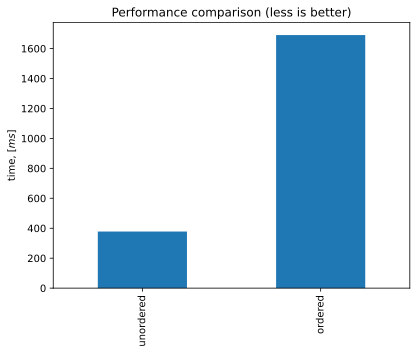

In [9]:
df.mean().plot.bar(
    title="Performance comparison (less is better)",
    ylabel="time, [$ms$]"
)

# Wnioski

- Teoria komunikujących się sekwencyjnych procesów (CSP) C.A.R. Hoare’a dostarcza formalne podejście do
  opisu współbieżności i zbiór technik projektowania współbieżnych programów.

- Procesy CSP nie mają wspólnej przestrzeni adresowej, nie mają interfejsu metod ani tożsamości, a komunikują
  się tylko za pomocą kanałów.
  
- Kanały CSP są synchroniczne, obsługują tylko odczyt i zapis, a podstawowym typem kanałów jest *one-to-one*.

- Pakiet JCSP, opracowany na University of Kent, to platforma wykonawcza dla programów współbieżnych w Javie,
  która wspiera konstrukcje CSP.

- W JCSP, interfejsy `ChannelInput`, `ChannelOutput` i `Channel` działają na argumentach typu `Object` lub `int`.

- Interfejs `CSProcess` opisuje procesy wspierając tylko metodę `run`.

- Operator wyboru `[]` jest obsługiwany za pośrednictwem klasy `Alternative`, która wspiera metody `select` i `fairSelect`. 

- Dodatkowo, JCSP oferuje narzędzia takie jak *timer*, `Generate`, `Skip` i klasy umożliwiające interakcję poprzez GUI.

- Jak widać z wykresu oraz tabeli, pobieranie elementów przez konsumenta bez zachowania kolejności (`unordered`) jest
  zdecydowanie szybsze niż z zachowaniem kolejności (`ordered`).

# Bibliografia

1. Materiały do laboratorium 13, dr inż. Włodzimierz Funika:\
   [https://home.agh.edu.pl/~funika/tw/lab-csp/](https://home.agh.edu.pl/~funika/tw/lab-csp/)

2. `Channel`, University of Kent JCSP Reference:\
   [https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html](https://www.cs.kent.ac.uk/projects/ofa/jcsp/jcsp-1.1-rc4/jcsp-doc/org/jcsp/lang/Channel.html)